In [49]:
%load_ext autoreload
%autoreload 2
import torch.nn as nn
import pandas as pd
import torch
import numpy as np
import torchvision
import torch.optim as optim
from dataset import train_loader, test_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2), nn.ReLU(), nn.BatchNorm2d(8),
    nn.Conv2d(8, 8, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(8),
    
    nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2), nn.ReLU(), nn.BatchNorm2d(16),
    nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2), nn.ReLU(), nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
    
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
    
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16),
    
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(16, 2, kernel_size=3, padding=1), nn.Tanh()
)

In [4]:
def train(model, optimizer, criterion, epochs=10, lrs=None):
    val_loss, val_acc = [], []
    for e in range(epochs):
        print(f"epoch: {e}")
        if lrs is not None: lrs.step()
        for inputs, labels in train_loader:
            model.train()
            inputs, labels = inputs.to('cuda'), labels.to('cuda') 

            optimizer.zero_grad()
            logits = model(inputs)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        vloss, vacc = get_validation_error(model)
        val_loss.append(vloss), val_acc.append(vacc)
    return pd.DataFrame({'loss': val_loss, 'acc': val_acc})

In [5]:
def get_validation_error(model):
    model.eval()
    loss = 0.0
    num = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        with torch.no_grad():
            a_out = model(inputs)
        _, yh = torch.max(a_out, 1)
        loss += criterion(a_out, labels).item() * labels.shape[0]
        num += labels.shape[0]
    print(f"Validation Loss: {loss/num}")
    return loss/num, 0.0

In [6]:
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.002)
lrs = None # StepLR(optimizer, step_size=7, gamma=0.1)
criterion = torch.nn.MSELoss()
epochs = 3
stats_lr = train(model, optimizer, criterion, epochs, lrs)

epoch: 0
Validation Loss: 0.03664839450149854
epoch: 1
Validation Loss: 0.03694076688635699
epoch: 2
Validation Loss: 0.03616396009743926


In [39]:
x,y = next(iter(train_loader))

In [40]:
with torch.no_grad():
    model.eval()
    xc = x.cuda()
    yhat = model(xc)

In [41]:
yhat = yhat.cpu()

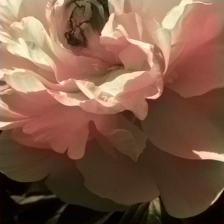

In [45]:
ds_train.normalized_lab_to_pil(x[2,:], yhat[2,:])

Its all sepiaed out =(, lets try mitigate some of that in our beta version